In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In this notebook, we'll combine the cluster enrichment results with the KEGG brite hierarchy to visualize the enriched pathways. 

In [3]:
# Load the clustering/enrichment results
clusters_df = pd.read_csv('../data/analysis/phaeocystis_O2_clusters_KEGG_MWU_results.csv')

# Remove the weird part of the annotation column
clusters_df['annotation'] = clusters_df['annotation'].str.split('ko:').str[1]

clusters_df.head()

,annotation,p_val,q_val,U,size,estimate,direction,Cluster
0,K06655,9.503198e-15,5.137317e-14,2356438.5,27,0.930383,top,1
1,K08820,9.503198e-15,5.137317e-14,2356438.5,27,0.930383,top,1
2,K15594,9.503198e-15,5.137317e-14,2356438.5,27,0.930383,top,1
3,K15596,9.503198e-15,5.137317e-14,2356438.5,27,0.930383,top,1
4,K02134,1.117534e-08,3.330135e-08,1369200.0,16,0.912255,top,1


In [4]:
# Parse the KEGG Brite categories
brite_file = '../data/annotation/functional_eggnog/kegg_brite.txt'
output_csv = '../data/annotation/functional_eggnog/kegg_brite.csv'

# Initialize variables to track levels
level_A = None
level_B = None
level_C = None
parsed_data = []

# Open and parse the KEGG Brite file
with open(brite_file, 'r') as f:
    for line in f:
        if line.startswith('A'):
            # Top-level category
            level_A = line.strip().split(' ')[-1]
        elif line.startswith('B'):
            # Second-level category
            level_B = line.strip().split(' ')[-2:]
            level_B = ' '.join(level_B)
        elif line.startswith('C'):
            # Third-level category
            level_C = line.strip().split('  ')[-1]
            # Remove the first element of the string
            level_C = level_C.split(' ')[1:]
            level_C = ' '.join(level_C)
            # Remove the last element of the string if it is between []
            level_C = level_C.split(' ')[0:-1] if level_C.endswith(']') else level_C.split(' ')
            level_C = ' '.join(level_C)
        elif line.startswith('D'):
            # Fourth-level category: contains KEGG KO data
            parts = line.strip().split('  ')
            if len(parts) > 1:
                ko_id = parts[3]  # KEGG KO ID
                ko_name = parts[-1]  # KEGG KO name
                parsed_data.append([level_A, level_B, level_C, ko_id, ko_name])

# Create a DataFrame from the parsed data
brite_df = pd.DataFrame(parsed_data, columns=['A_level', 'B_level', 'C_level', 'KEGG_KO', 'KO_name'])
brite_df.head()
# Save the parsed data to a CSV file
#brite_df.to_csv(output_csv, index=False)

,A_level,B_level,C_level,KEGG_KO,KO_name
0,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,K00844,HK; hexokinase [EC:2.7.1.1]
1,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,K12407,GCK; glucokinase [EC:2.7.1.2]
2,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,K00845,glk; glucokinase [EC:2.7.1.2]
3,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,K25026,glk; glucokinase [EC:2.7.1.2]
4,Metabolism,Carbohydrate metabolism,Glycolysis / Gluconeogenesis,K01810,"GPI, pgi; glucose-6-phosphate isomerase [EC:5...."


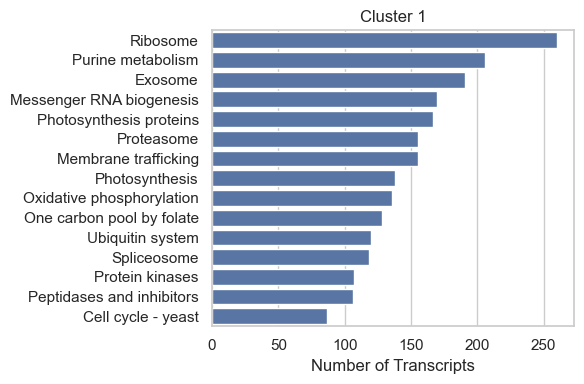

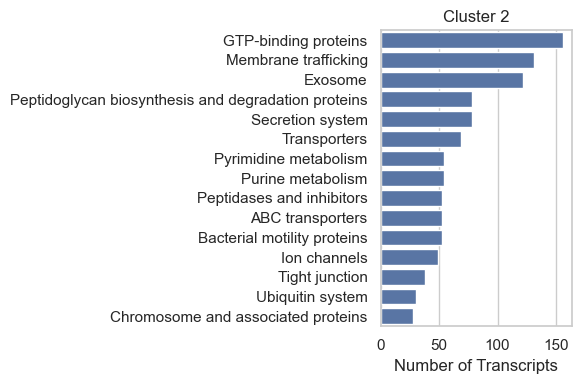

In [6]:
# Merge clustering/enrichment results with KEGG Brite categories
merged_df = clusters_df.merge(brite_df, how='left', left_on='annotation', right_on='KEGG_KO')

# Aggregate by cluster and C-level
cluster_c_agg = merged_df.groupby(['Cluster', 'C_level'])['size'].sum().reset_index()

# Plot barplots for each cluster
clusters = cluster_c_agg['Cluster'].unique()

# Set Seaborn style
sns.set(style="whitegrid")

# Iterate through each cluster to create bar plots
for cluster in clusters:
    cluster_data = cluster_c_agg[cluster_c_agg['Cluster'] == cluster]
    cluster_data = cluster_data.sort_values(by='size', ascending=False)
    
    # Only plot the top 15 categories
    cluster_data = cluster_data.head(15)
    
    # Create the bar plot using Seaborn
    plt.figure(figsize=(6, 4))
    sns.barplot(
        data=cluster_data, 
        y='C_level', 
        x='size'
    )
    
    # Add labels and titles
    plt.xlabel('Number of Transcripts', fontsize=12)
    plt.ylabel(None)
    plt.title(f'Cluster {cluster}', fontsize=12)
    plt.tight_layout()
    
    # Save the plot
    plt.savefig(f'../figures/metatranscriptomics/cluster_{cluster}_kegg_enriched_categories.svg', dpi=800)
    plt.savefig(f'../figures/metatranscriptomics/cluster_{cluster}_kegg_enriched_categories.png', dpi=800)
    plt.show()

In [31]:
# Check what specifically is included in the clusters
merged_df[merged_df['C_level'] == 'Chromosome and associated proteins']

,annotation,p_val,q_val,U,size,estimate,direction,Cluster,A_level,B_level,C_level,KEGG_KO,KO_name
43,K20720,7.701015e-05,1.418283e-04,933726.0,12,0.829483,top,1,Hierarchies,information processing,Chromosome and associated proteins,K20720,RTN4; reticulon-4
45,K20721,7.701015e-05,1.418283e-04,933726.0,12,0.829483,top,1,Hierarchies,information processing,Chromosome and associated proteins,K20721,RTN1; reticulon-1
47,K20722,7.701015e-05,1.418283e-04,933726.0,12,0.829483,top,1,Hierarchies,information processing,Chromosome and associated proteins,K20722,RTN2; reticulon-2
49,K20723,7.701015e-05,1.418283e-04,933726.0,12,0.829483,top,1,Hierarchies,information processing,Chromosome and associated proteins,K20723,RTN3; reticulon-3
230,K11659,3.107793e-02,3.921007e-02,540371.0,8,0.720065,top,1,Hierarchies,information processing,Chromosome and associated proteins,K11659,RBBP7; histone-binding protein RBBP7
237,K19347,3.456385e-02,4.327545e-02,925217.5,15,0.657540,top,1,Hierarchies,information processing,Chromosome and associated proteins,K19347,SUN1_2; SUN domain-containing protein 1/2
365,K19788,8.080305e-08,3.853684e-07,325957.5,17,0.875804,top,2,Hierarchies,information processing,Chromosome and associated proteins,K19788,OLA1; obg-like ATPase 1
382,K09189,9.698708e-05,2.605491e-04,126033.0,6,0.959462,top,2,Hierarchies,information processing,Chromosome and associated proteins,K09189,MLL5; [histone H3]-lysine4 N-trimethyltransfer...
448,K02209,4.507498e-02,6.235164e-02,83056.5,5,0.758749,top,2,Hierarchies,information processing,Chromosome and associated proteins,K02209,"MCM5, CDC46; DNA replication licensing factor ..."
